### Setup

In [1]:
# install if not yet done
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating registry at `C:\Users\domin\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`
   Installed SimpleBufferStream ─ v1.2.0
  No Changes to `C:\Users\domin\OneDrive\Desktop\Julia Files\Dragoon.jl\Project.toml`
    Updating `C:\Users\domin\OneDrive\Desktop\Julia Files\Dragoon.jl\Manifest.toml`
  [777ac1f9] ↑ SimpleBufferStream v1.1.0 ⇒ v1.2.0
Precompiling project...
  ✓ SimpleBufferStream
  ✓ HTTP
  2 dependencies successfully precompiled in 4 seconds. 229 already precompiled. 1 skipped during auto due to previous errors.


In [2]:
using Dragoon
using Plots

In [48]:
n = 20 # number of discs in the booster

cf = 10.025e9

initdist = findpeak1d(cf,n; granularity=10_000,deviation=0.3) # initial disc configuration

freqs = genFreqs(cf,50e6; n=10) # optimize on these frequencies
freqsplot = genFreqs(cf,150e6; n=1000) # plot with these frequencies

booster = AnalyticalBooster(initdist; ndisk=n)  # physical properties of the booster

obj = ObjAnalytical

hist = initHist(booster,2*(booster.ndisk^2),freqs,obj);

### Optimizer

In [52]:
trace = nelderMead(booster,hist,freqs,
                    1.,1+2/n,0.75-1/2n,1-1/n,1e-12,
                    obj,
                    InitSimplexRegular(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(1e5),
                    showtrace=true,
                    showevery=10000,
                    unstuckisiter=true,);

Iter: 10000, timestamp: 5 minutes, 54 seconds
Iter finished. Objective value: -5391.823

Iter: 20000, timestamp: 6 minutes, 40 seconds
Iter finished. Objective value: -5433.942

Iter: 30000, timestamp: 7 minutes, 42 seconds
Iter finished. Objective value: -5454.992

Iter: 40000, timestamp: 8 minutes, 19 seconds
Iter finished. Objective value: -5480.334

Iter: 50000, timestamp: 8 minutes, 33 seconds
Iter finished. Objective value: -5488.127

Iter: 60000, timestamp: 8 minutes, 46 seconds
Iter finished. Objective value: -5492.061

Iter: 70000, timestamp: 8 minutes, 52 seconds
Iter finished. Objective value: -5495.007

Iter: 80000, timestamp: 8 minutes, 52 seconds
Iter finished. Objective value: -5495.41

Iter: 90000, timestamp: 8 minutes, 52 seconds
Iter finished. Objective value: -5495.666

Iter: 100000, timestamp: 8 minutes, 52 seconds
Iter finished. Objective value: -5495.745

Terminated. Max iterations reached.
Final objective value: -5495.745
Elapsed movement time:  8 minutes, 52 sec

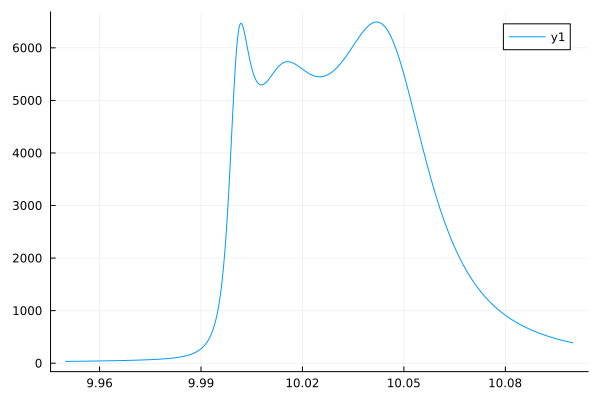

In [53]:
p0 = copy(booster.pos)

plot(freqsplot/1e9,getBoost1d(booster,freqsplot))

In [56]:
move(booster,p0; additive=false)

o,s,s_ = dragoon(booster,hist,50e6,5e6,
        obj,UnstuckExpand(2,12_000);
        fmin=10.0e9,fmax=30.0e9,nfreqs=10,
        scalerange=(1.0,1.3),scalesteps=1000)

(Any[-5497.093560398034, -5540.730315425689, -5568.791633820951, -5623.787416233555, -5665.435630309177, -5703.040513505214, -5736.614015613753, -5771.581440571195, -5796.9004660059545, -5836.844844956111  …  -7168.252304751673, -7025.638671764135, -6875.0903841564905, -6716.388881768778, -6544.868069930424, -6371.3154557492835, -6183.412577596629, -6000.791376172337, -5746.967534654772, -5507.612575004942], Any[0.9955201592832255, 0.9955401387512388, 0.9955599407992106, 0.9955795677799607, 0.9955990220048899, 0.9956183057448881, 0.9956374212312167, 0.9956563706563707, 0.9956751561749159, 0.9956937799043062  …  0.9984807562457799, 0.9984830608461149, 0.9984853584651633, 0.9984876491345992, 0.998489932885906, 0.998492209750377, 0.9984944797591168, 0.9984967429430432, 0.9984989993328885, 0.9985012489592007], Any[1.1578, 1.1566, 1.1533, 1.1545, 1.1533, 1.1524, 1.1515, 1.1509, 1.1491, 1.1488  …  1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3])

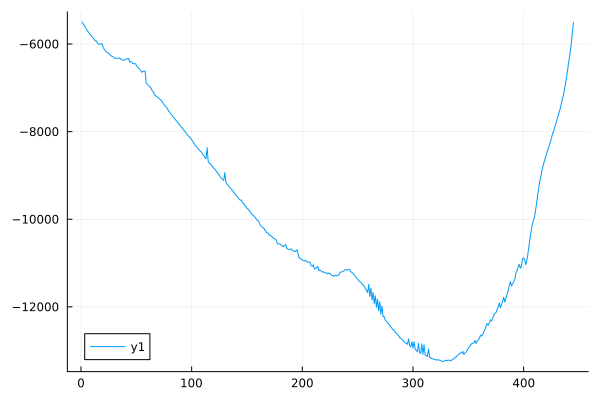

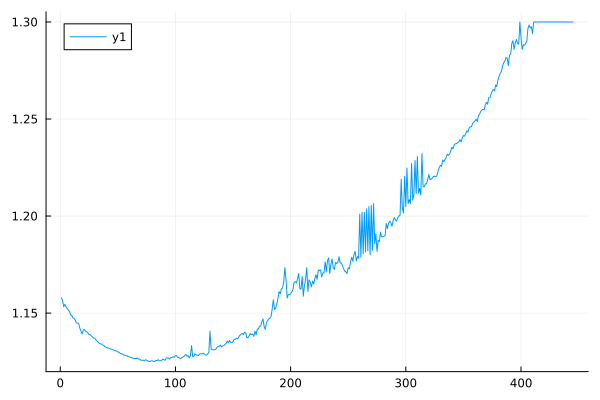

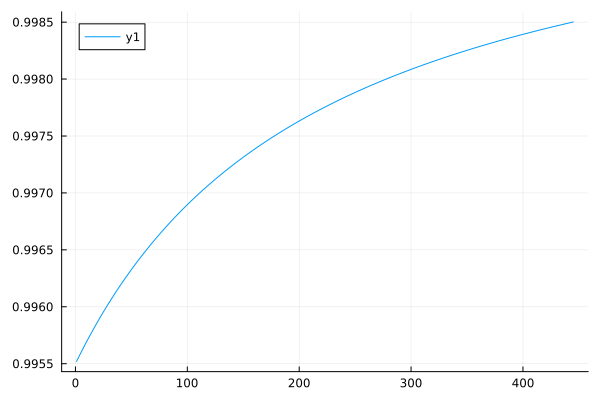

In [57]:
display(plot(o))
display(plot(s_))
display(plot(s))